In [16]:
import tensorflow
import torch
import os
import pandas as pd
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
import torch.nn as nn
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import random
from tensorflow import keras

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

csv_file_path = '../../data/clocks.csv'
clocks_csv = pd.read_csv(csv_file_path)

classes_number = clocks_csv['class index'].unique()

class_index_to_label_map = dict(zip(clocks_csv['class index'], clocks_csv['labels']))
classes_number.__len__()

144

In [18]:
def create_dataframes(dataset_type, transforms):
    dataset = []
    df = clocks_csv[clocks_csv['data set'] == dataset_type]
    for index, row in df.iterrows():
        with Image.open(os.path.join('../../data/', row['filepaths'])) as img:
            img_transform = transforms(img)
            label = row['class index']
            dataset.append([img_transform, label])
    return dataset

In [19]:
# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

val_and_test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = create_dataframes('train', val_and_test_transform)
valid_data = create_dataframes('valid', val_and_test_transform)
test_data = create_dataframes('test', val_and_test_transform)
random.shuffle(train_data)
train_dataset = pd.DataFrame(train_data)
valid_dataset = pd.DataFrame(valid_data)
test_dataset = pd.DataFrame(test_data)

In [20]:
batch_size = 32
epochs = 200
data_augmentation = True
num_classes = 144
lr = 1e-04

subtract_pixel_mean = True
n = 3

depth = n * 9 + 2

model_type = f'ResNet {depth}'

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=batch_size, shuffle=False,
        num_workers=4, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size, shuffle=False,
        num_workers=4, pin_memory=True)

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


             5_20              5_45              8_30              9_25             12_55             12_10              3_25              9_50


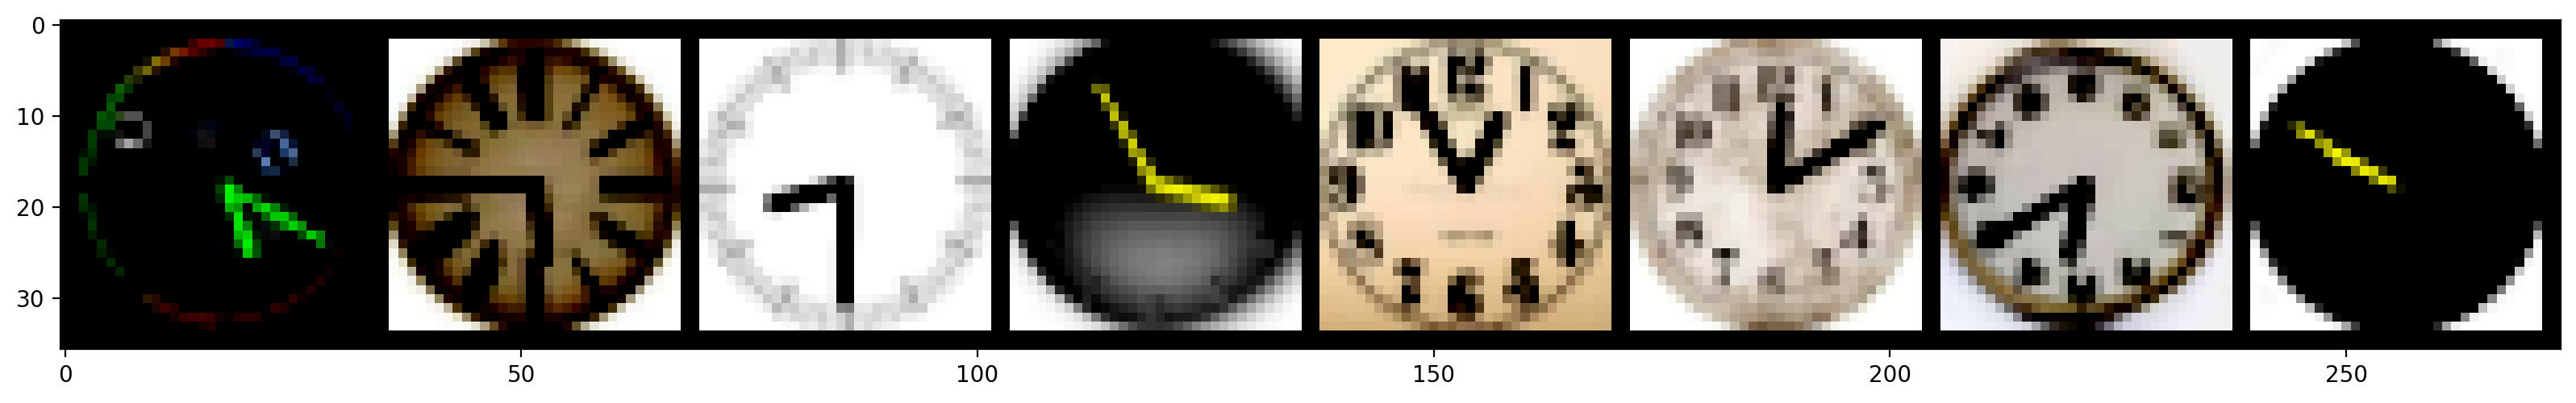

In [22]:
images, labels = list(train_dataset[0].to_numpy()), train_dataset[1].to_numpy()
plt.figure(figsize=(20,10)) 

imshow(torchvision.utils.make_grid(images[:8]))

print(' '.join('%17s' % class_index_to_label_map[list(class_index_to_label_map.keys())[labels[j]]] for j in range(8)))

In [23]:
def split_to_x_y(dataset):
    x_ = []
    y_ = []
    for i in range (len(dataset)):
        x_.append(torch.transpose(dataset[i][0], 0, 2))
        y_.append(dataset[i][1])
    return x_, y_  

In [24]:
x_train, y_train = split_to_x_y(train_dataset.to_numpy())
x_val, y_val = split_to_x_y(valid_dataset.to_numpy())
x_test, y_test =  split_to_x_y(test_dataset.to_numpy())

In [25]:
def to_numpy(data):
    data_ = []
    for i in range(0, len(data)):
        data_ += [np.array(data[i])]
    return np.array(data_)

In [26]:
X_train = to_numpy(x_train)
Y_train = to_numpy(y_train)

X_val = to_numpy(x_val)
Y_val = to_numpy(y_val)

X_test = to_numpy(x_test)
Y_test = to_numpy(y_test)

In [27]:
Y_train = keras.utils.to_categorical(Y_train, 144)
Y_val = keras.utils.to_categorical(Y_val, 144)
Y_test = keras.utils.to_categorical(Y_test, 144)

In [28]:
inputs = keras.Input(shape=(32, 32, 3), name="img")

x = keras.layers.Conv2D(32, 3, activation="relu")(inputs)
x = keras.layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = keras.layers.MaxPooling2D(3)(x)

x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = keras.layers.add([x, block_1_output])

x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = keras.layers.add([x, block_2_output])

x = keras.layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x =keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(144, activation='softmax')(x)
model = keras.Model(inputs, outputs, name="toy_resnet")

In [29]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
model.fit(X_train, Y_train, batch_size=64, epochs=60, validation_split=0.2)

Epoch 1/60
144/144 [==============================] - 26s 161ms/step - loss: 4.9719 - accuracy: 0.0068 - val_loss: 4.9716 - val_accuracy: 0.0069
Epoch 2/60
144/144 [==============================] - 23s 158ms/step - loss: 4.7863 - accuracy: 0.0131 - val_loss: 4.3751 - val_accuracy: 0.0156
Epoch 3/60
144/144 [==============================] - 23s 158ms/step - loss: 4.0153 - accuracy: 0.0471 - val_loss: 3.3382 - val_accuracy: 0.1207
Epoch 4/60
144/144 [==============================] - 23s 158ms/step - loss: 3.3332 - accuracy: 0.1094 - val_loss: 2.6886 - val_accuracy: 0.2565
Epoch 5/60
144/144 [==============================] - 23s 158ms/step - loss: 2.5724 - accuracy: 0.2364 - val_loss: 1.7479 - val_accuracy: 0.4913
Epoch 6/60
144/144 [==============================] - 23s 158ms/step - loss: 1.8880 - accuracy: 0.3891 - val_loss: 1.1966 - val_accuracy: 0.6506
Epoch 7/60
144/144 [==============================] - 23s 158ms/step - loss: 1.3931 - accuracy: 0.5317 - val_loss: 0.8080 - val_ac

In [31]:
print(model.evaluate(X_val, Y_val))

45/45 [==============================] - 1s 19ms/step - loss: 0.0971 - accuracy: 0.9715
[0.09707260876893997, 0.9715277552604675]


In [32]:
print(model.evaluate(X_test, Y_test))

45/45 [==============================] - 1s 19ms/step - loss: 0.1119 - accuracy: 0.9736
[0.11189623922109604, 0.9736111164093018]


1/1 [==============================] - 0s 247ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0
Предсказанный класс 1_00, Реальный класс 1_00


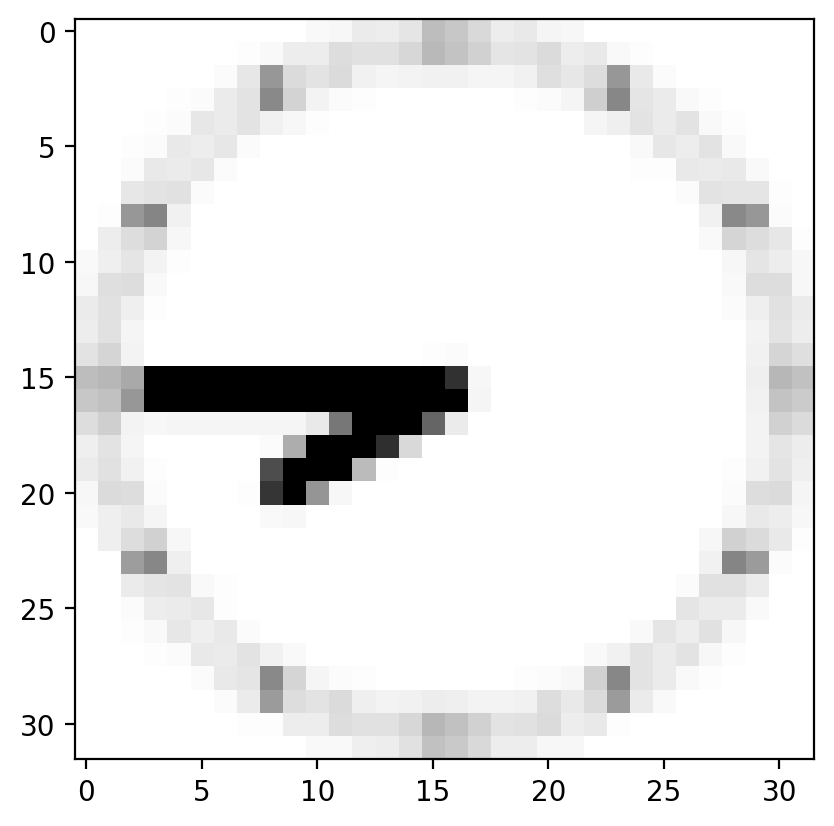

In [33]:
ind = 2
preds = model.predict(np.expand_dims(X_test[ind], axis=0))[0]

pred_class = max(enumerate(preds),key=lambda x: x[1])[0]
real_class = max(enumerate(Y_test[ind]),key=lambda x: x[1])[0]
print(pred_class, real_class)
plt.imshow(X_test[ind])
print(f"Предсказанный класс {class_index_to_label_map[pred_class]}, Реальный класс {class_index_to_label_map[real_class]}")